<a id="top"></a>

<a id = '1.0'></a>
<h1 style = "font-family: garamond; font-size: 40px; font-style: normal;background-color: #2ab7ca; color : #fed766; border-radius: 5px 5px;padding:5px;text-align:center; font-weight: bold" >Quick Navigation</h1>

    
* [Dependencies and Configuration](#1)
* [Stage 4: Modelling](#2)
    * [How EDA helped us?](#31)
    * [Modelling](#31)
        * [Spot Checking Algorithms](#31)
            * [Make Basic Pipeline (Say No to Data Leakage!)](#31)
            * [Define Metrics](#31)
            * [Comparison of Cross-Validated Models](#31)
            * [Out-of-Fold Confusion Matrix](#31)
            * [Hypothesis Testing Across Models](#31)
        * [Model Selection: Hyperparameter Tuning with GridSearchCV](#31)
        * [Retrain on the whole training set](#31)
            * [Retrain using Optimal Hyperparameters](#31)
        * [Interpretation of Results](#31)
            * [Interpretation of Coefficients](#31)
            * [Interpretation of Metric Scores on Train Set](#31)
    * [Evaluation on Test Set](#31)
    * [Bias-Variance Tradeoff](#31)

# TODO

To use logging instead of print.

---

We define a `make_pipeline` function here to define our steps needed. 

**TODO: To allow the function to take in dynamic parameters, maybe a list of steps can be passed in so that it is less hardcoded within the function.**

---

# Dependencies and Configuration

In [1]:
# !pip install gcloud == 0.18.3
import csv
import random
from functools import wraps
from time import time
from typing import Callable, Dict, List, Union, Optional, Any

import matplotlib.pyplot as plt
import copy
import mlxtend
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.evaluate import paired_ttest_5x2cv, bias_variance_decomp
from scipy import stats
from sklearn import (base, decomposition, dummy, ensemble, feature_selection,
                     linear_model, metrics, model_selection, neighbors,
                     pipeline, preprocessing, svm, tree)

from statsmodels.regression.linear_model import OLS
#from statsmodels.stats.outliers_influence import variance_inflation_factor

from dataclasses import dataclass, field
import logging

In [2]:
@dataclass
class config:
    raw_data: str = "https://storage.googleapis.com/reighns/reighns_ml_projects/docs/supervised_learning/classification/breast-cancer-wisconsin/data/raw/data.csv"
    processed_data: str = "https://storage.googleapis.com/reighns/reighns_ml_projects/docs/supervised_learning/classification/breast-cancer-wisconsin/data/processed/processed.csv"
    train_size: float = 0.9
    seed: int = 1992
    num_folds: int = 5
    cv_schema: str = "StratifiedKFold"
    classification_type: str = "binary"
    
    target_col: List[str] = field(default_factory = lambda: ["diagnosis"])
    unwanted_cols : List[str] =  field(default_factory = lambda: ["id", "Unnamed: 32"])
    
    # Plotting
    colors : List[str] =field(default_factory = lambda: ["#fe4a49", "#2ab7ca", "#fed766", "#59981A"])
    cmap_reversed = plt.cm.get_cmap('mako_r')
    
#     spot_checking_boxplot = "../data/images/spot_checking_boxplot.png"
#     oof_confusion_matrix = "../data/images/oof_confusion_matrix.png"
#     final_train_confusion_matrix = "../data/images/final_train_confusion_matrix.png"
#     precision_recall_threshold_plot = "../data/images/precision_recall_threshold_plot.png"
#     roc_plot = "../data/images/roc_plot.png"
#     feature_importance = "../data/images/feature_importance.png"

In [3]:
def set_seeds(seed: int = 1234) -> None:
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    
def init_logger(log_file: str = "info.log"):
    """
    Initialize logger.
    """
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(logging.Formatter("%(asctime)s - %(message)s", datefmt= "%Y-%m-%d,%H:%M:%S"))
    file_handler = logging.FileHandler(filename=log_file)
    file_handler.setFormatter(logging.Formatter("%(asctime)s - %(message)s",  datefmt= "%Y-%m-%d,%H:%M:%S"))
    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
    return logger

In [4]:
config = config()
logger = init_logger()

In [5]:
# set seeding for reproducibility
_ = set_seeds(seed = config.seed)

# read data
df = pd.read_csv(config.processed_data)

# Cross-Validation Strategy

<div class="alert alert-block alert-danger">
<b>Generalization:</b>     
    <blockquote cite="https://www.huxley.net/bnw/four.html">
        <p>Ultimately, we are interested in the Generalization Error made by the model, that is, how well the model perform on <b>unseen data</b> that is not taken from our sample set $\mathcal{D}$. In general, we use <b>validation set</b> for <b>Model Selection</b> and the <b>test set</b> for <b>an estimate of generalization error</b> on new data.
            <br> <b>- Refactored from Elements of Statistical Learning, Chapter 7.2</b></p>
    </blockquote>
</div>

---

<div class="alert alert-success" role="alert">
    <b>Step 1: Train-Test-Split:</b> Since this dataset is relatively small, we will not use the <b>train-validation-test</b> split and only split into train and test in a ratio of 9:1, whereby the split is stratified on our target, using <code>stratify=y</code> parameter in <code>train_test_split()</code> to ensure that our target has equal representation in both train and test. We note that this is a relatively small dataset and in practice, we need a large sample size to get a reliable/stable split, it is also recommended to retrain the whole dataset (without the "unseen" test set) after we have done the model selection process (eg. finding best hyperparameters). 
</div>

---

<div class="alert alert-success" role="alert">
    <b>Step 2: Resampling Stategy:</b> Note that we will be performing <code>StratifiedKFold</code> as our resampling strategy. After our split in Step 1, we have a training set $X_{\text{train}}$, we will then perform our resampling strategy on this $X_{\text{train}}$. We will choose our choice of $K = 5$. The choice of $K$ is somewhat arbitrary, and is derived <a href="https://stats.stackexchange.com/questions/61783/bias-and-variance-in-leave-one-out-vs-k-fold-cross-validation">empirically</a>. 
</div>

---

To recap, we have the following:

- **Training Set ($X_{\text{train}}$)**: This will be further split into K validation sets during our cross-validation. This set is used to fit a particular hypothesis $h \in \mathcal{H}$.
- **Validation Set ($X_{\text{val}}$)**: This is split from our $X_{\text{train}}$ during cross-validation. This set is used for model selection (i.e. find best hyperparameters, attempt to produce a best hypothesis $g \in \mathcal{H}$).
- **Test Set ($X_{\text{test}}$)**: This is an unseen test set, and we will only use it after we finish tuning our model/hypothesis. Suppose we have a final best model $g$, we will use $g$ to predict on the test set to get an estimate of the generalization error (also called out-of-sample error).

---

<figure>
<img src='https://scikit-learn.org/stable/_images/grid_search_workflow.png' width="500"/>
<figcaption align = "center"><b>Courtesy of scikit-learn on a typical Cross-Validation workflow.</b></figcaption>
</figure>

In [6]:
X = df.copy()
y = X.pop("diagnosis")

In [7]:
predictor_cols = X.columns.to_list()

In [8]:
# Split train - test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=config.train_size, shuffle=True, stratify= y, random_state=config.seed)

We confirm that we have stratified properly. We do observe that the distribution of targets in both `y_train` and `y_test` are similar.

In [9]:
logger.info(f"Y Train Distribution is : {y_train.value_counts(normalize=True).to_dict()}")
logger.info(f"Y Test Distribution is : {y_test.value_counts(normalize=True).to_dict()}")

2021-11-10,13:35:37 - Y Train Distribution is : {0: 0.626953125, 1: 0.373046875}
2021-11-10,13:35:37 - Y Test Distribution is : {0: 0.631578947368421, 1: 0.3684210526315789}


In [10]:
def make_folds(
    df: pd.DataFrame,
    num_folds: int,
    cv_schema: str,
    seed: int,
    predictor_col: List,
    target_col: List,
) -> pd.DataFrame:
    """Split the given dataframe into training folds.

    Args:
        df (pd.DataFrame): [description]
        num_folds (int): [description]
        cv_schema (str): [description]
        seed (int): [description]

    Returns:
        pd.DataFrame: [description]
    """

    if cv_schema == "KFold":
        df_folds = df.copy()
        kf = model_selection.KFold(n_splits=num_folds, shuffle=True, random_state=seed)

        for fold, (train_idx, val_idx) in enumerate(
            kf.split(X=df_folds[predictor_col], y=df_folds[target_col])
        ):
            df_folds.loc[val_idx, "fold"] = int(fold + 1)

        df_folds["fold"] = df_folds["fold"].astype(int)

    elif cv_schema == "StratifiedKFold":
        df_folds = df.copy()
        skf = model_selection.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

        for fold, (train_idx, val_idx) in enumerate(
            skf.split(X=df_folds[predictor_col], y=df_folds[target_col])
        ):
            df_folds.loc[val_idx, "fold"] = int(fold + 1)

        df_folds["fold"] = df_folds["fold"].astype(int)
        print(df_folds.groupby(["fold", "diagnosis"]).size())

    return df_folds

In [11]:
X_y_train = pd.concat([X_train, y_train], axis = 1).reset_index(drop=True)
df_folds = make_folds(X_y_train, num_folds=config.num_folds, cv_schema=config.cv_schema, seed=config.seed, predictor_col= predictor_cols, target_col = config.target_col)

fold  diagnosis
1     0            64
      1            39
2     0            65
      1            38
3     0            64
      1            38
4     0            64
      1            38
5     0            64
      1            38
dtype: int64


Looks good! All our five folds are stratified!

# Define Metrics

**Disclaimer: For a more detailed understanding of different metrics, do navigate to my self-made notes on metrics.**

---

Choosing a metric to measure the classifier's (hypothesis) performance is important, as choosing the wrong one can lead to disastrous interpretations. One prime example is using the accuracy metric for imbalanced datasets; consider 1 mil data points, dichotomized by $99\%$ benign and $1\%$ malignant samples, even a baseline model zeroR model which predicts the majority class no matter the process will give a $99\%$ \textbf{accuracy}, completely missing out any positive samples, which unfortunately, is what we may be more interested in.

---

<div class="alert alert-block alert-danger">
<b>Say No to Accuracy:</b> Consider an imbalanced set, where the training data set has 100 patients (data points), and the ground truth is 90 patients are of class = 0, which means that these patients do not have cancer, whereas the remaining 10 patients are in class 1, where they do have cancer. This is an example of class imbalance where the ratio of class 1 to class 0 is 1:9.
</div>   
    
Consider **a baseline (almost trivial) classifier**:

```python
def zeroR(patient_data):
        training...
    return benign
```
        

where we predict the patient's class as the most frequent class. Meaning, the most frequent class in this question is the class = 0, where patients do not have cancer, so we just assign this class to everyone in this set. By doing this, we will inevitably achieve a **in-sample** accuracy rate of $\frac{90}{100} = 90\%$. But unfortunately, this supposedly high accuracy value is completely useless, because this classifier did not label any of the cancer patients correctly.

The consequence can be serious, assuming the test set has the same distribution as our training set, where if we have a test set of 1000 patients, there are 900 negative and 100 positive. Our model just literally predict every one of them as benign, yielding a $90\%$ **out-of-sample** accuracy.

What did we conclude? Well, for one, our `accuracy` can be 90% high and looks good to the laymen, but it failed to predict the most important class of people - yes, misclassifying true cancer patients as healthy people is very bad! 

---

For the reasons mentioned above, we will use metric that can help us reduce False Negatives, and at the same time, outputs meaningful predictions. In order to achieve for both, we will use **Receiver operating characteristic (ROC)** as the primary metric for the model to maximize (which is our $\mathcal{M}$, and **Brier Score**, a [proper scoring rule](https://en.wikipedia.org/wiki/Scoring_rule) to measure the performance of our probabilistic predictions. We will go into some details in the next two subsections to justify our choice.

## Proper Scoring Rule

The math behind the idea of Proper Scoring Rule is non-trivial. Here, we try to understand why a proper scoring rule is desired in the context of binary classification.

---

<div class="alert alert-success" role="alert">
<li> <b>Strictly Proper Scoring Rule:</b> Brier Score Loss, for example, tells us that the best possible score, 0 (lowest loss), is obtained if and only if, the probability prediction we get for a sample, is the true probability itself. In other words, if a selected sample is of class 1, our prediction for this must be 1, with 100% probability, in order to get a score loss of 0.
    
<li> <b>Proper Scoring Rule:</b> Read [here](https://stats.stackexchange.com/questions/339919/what-does-it-mean-that-auc-is-a-semi-proper-scoring-rule) for this.
    
<li> <b>Semi Proper Scoring Rule:</b> AUROC, as mentioned, does not help out in telling whether a prediction by a classifier is close to the true probability or not. In our example, we even see that we can obtain a full score of 1, even if the probabilities all lie within 0.51 and 0.52.

<li> <b>Improper Scoring Rule:</b> Accuracy is a prime example, the accuracy score does not, whatsoever, tells us about how close our predicted probabilities are, to the true probability distribution of our samples.
</div>

## Receiver operating characteristic (ROC)

<div class="alert alert-success" role="alert">
    <b>Definition:</b> The basic (non-probablistic intepretation) of ROC is graph that plots the True Positive Rate on the y-axis and False Positive Rate on the x-axis parametrized by a threshold vector $\vec{t}$. We then look at the area under the ROC curve (AUROC) to get an overall performance measure.
</div>

---

The choice of ROC over other metrics such as Accuracy is detailed initially. **We also established we want to reduce False Negative (FN), since misclassifying a positive patient as benign is way more costly than the other way round.** One can choose to minimize **Recall** in order to reduce FN, but this is less than ideal during training because it is a thresholded metric, and does not provide at which threshold the recall is at minimum. This leads us to choose ROC for the following two main reasons:

### Threshold Invariant

By definition, ROC computes the pair $TPR \times FPR$ over all thresholds $t$, consequently, the AUROC is threshold invariant, allowing us to look at the model's performance over all thresholds. We note that ROC may not be that reliable in the case of very imbalanced datasets where majority is in the negative class, as $FPR = \dfrac{FP}{FP+TN}$ may seem deceptively low as denominator may be made small by the sheer amount of TN, in this case, we may also look at the Precision-Recall curve.

### Scale Invariant

Technically, this is not the desired property that we need, as this means that the ROC is non-proper in scoring, it can take in non-calibrated scores and still perform relatively well. A classic example I always use is the following:

```python
y1 = [1,0,1,0]
y2 = [0.52,0.51,0.52,0.51]
y3 = [52,51,52,51]
uncalibrated_roc = roc(y1,y2) == roc(y1,y3)
print(f"{uncalibrated_roc}") -> 1.0
```

The example tells us two things, as long as the ranking of predictions is preserved, the final AUROC score is the same, regardless of scale. We also notice that even though the model gives very unconfident predictions, the AUROC score is 1, which can be misleadingly over-optimistic. With that, we introduce Brier Score.

### Common Pitfalls

<div class="alert alert-block alert-danger">
<b>Careful when using ROC function!</b>   
    
We also note that when passing arguments to scikit-learn's <code>roc_auc_score</code> function, we should be careful not to pass <code>y_score=model.predict(X)</code> inside as we have to understand that we are passing in <b>non-thresholded</b> probabilities into <code>y_score</code>. If you pass the predicted values (full of 0 and 1s), then you are thresholding on 0 and 1 only, which is incorrect by definition. 
</div>

## Brier Score

<div class="alert alert-success" role="alert">
    <b>Definition:</b> Brier Score computes the squared difference between the probability of a prediction and its actual outcome. 
</div>

---

[Brier Score](https://en.wikipedia.org/wiki/Brier_score) is a strictly proper scoring rule while ROC is [not](https://www.fharrell.com/post/class-damage/); the lower the Brier Score, the better the predictions are calibrated. We can first compute the AUROC score of the model, and compute Brier Score to give us how well calibrated (confident) the predictions are.

### Well Calibrated

A intuitive way of understanding well calibrated probabilities is as follows, extracted from [cambridge's probability calibration](https://blog.cambridgespark.com/probability-calibration-c7252ac123f):

> In very simple terms, these are probabilities which can be interpreted as a confidence interval. Furthermore, a classifier is said to produce well calibrated probabilities if for the instances (data points) receiving probability 0.5, 50% of those instances belongs to the positive class.

---

In my own words, if a classifier is well calibrated, say in our context where we predict binary target, and pretend that out of our test set, 100 of the samples have a probability of around 0.1, then this means 10% of these 100 samples actually belong to the positive class.

The generic steps are as follows to calculate a calibrated plot:

1. Sort all the samples by the classifier's predicted probabilities, in either ascending or descending order.
2. Bin your diagram into N bins, usually we take 10, which means on the X-axis, note this does not mean we have 0-0.1, 0.1-0.2, ..., 0.9-1 as the 10 bins.
3. What step 2 means is let's say you have 100 predictions, if you bin by 10 bins, and since the predictions are ***sorted***, we can easily divide the 100 predictions into 10 intervals: for illustration, assume the 100 predictions are as follows, where we sort by ascending order and the prediction 0.1 has 10 of them, 0.2 have 10 of them, so on and so forth.
    ```python
    y_pred = [0.1, 0.1, ....., 0.2, 0.2, ..., 0.9, 0.9, ..., 1, 1, ...1]
    ```
4. Since we can divide the above into 10 bins, bin 1 will have 10 samples of predictions 0.1, bin 2 will have 10 samples of predictions 0.2, etc. We then take the mean of the **predictions of each bin**, that is for the first bin, we calculate $\dfrac{1}{10}\sum_{i=1}^{10}0.1 = 0.1$, and second bin, $\dfrac{1}{10}\sum_{i=1}^{10}0.2 = 0.2$. Note that this may not be such a nice number in reality, I made this example for the ease of illustration!
5. Now, we have our X-axis from step 4, that is, we turned 10 bins, into 10 numbers, 0.1, 0.2, 0.3, ..., 1, and then we need to find the corresponding points for each of the 10 numbers! This is easy, for 0.1, the corresponding y-axis is just the **fraction of positives**, which means, out of the 10 samples in the first bin, how many of these 10 samples were actually positive? We do this for all 10 bins (points), and plot a line graph as seen in scikit-learn.  

---

Now this should be apparent now that a well calibrated model should lie close to the $y = x$ line. That is, if the mean predicted probability is 0.1, then the y-axis should also be 0.1, meaning to say that out of all the samples that were predicted as 0.1, we should really only have about 10% of them being positive. The same logic applies to the rest!

---

### Brier Score Loss

Brier Score Loss is a handy metric to measure whether a classifier is well calibrated, as quoted from [scikit-learn](https://scikit-learn.org/stable/modules/calibration.html):

> Brier Score Loss may be used to assess how well a classifier is calibrated. However, this metric should be used with care because a lower Brier score does not always mean a better calibrated model. This is because the Brier score metric is a combination of calibration loss and refinement loss. Calibration loss is defined as the mean squared deviation from empirical probabilities derived from the slope of ROC segments. Refinement loss can be defined as the expected optimal loss as measured by the area under the optimal cost curve. As refinement loss can change independently from calibration loss, a lower Brier score does not necessarily mean a better calibrated model.

### Common Pitfalls

<div class="alert alert-block alert-danger">
<b>Class Imbalance:</b> The good ol' class imbalance issue almost always pop up anywhere and everywhere. Intuitively, if we have a super rare positive/negative class, then if the model is very confident in its predictions for the majority class, but not so confident on the rare class, the overall Brier Score Loss may not be sufficient in discriminating the classifier's inability in correctly classifying the minority class.
</div>

# Spot Checking Algorithms

<div class="alert alert-success" role="alert">
    <b>Terminology Alert!</b> This method is advocated by <a href="https://machinelearningmastery.com/">Jason Brownlee PhD</a> and this serves as the first stage of my modelling process. We will rapidly test (spot check) different classifier algorithms, from <code>DummyClassifier</code>, to <code>LinearModel</code> to more sophisticated ensemble trees like <code>RandomForest</code>. 
</div>

---

I also note to the readers that we need to think of a few things when choosing the "optimal" machine learning algorithm:

- [No Lunch Free Theorem](https://en.wikipedia.org/wiki/No_free_lunch_theorem) intuitively says that no single optimization algorithm can work best in all situations. Therefore, spot checking can help us form a basis of which algorithm might work better in this particular scenario.
- [Occam's Razor](https://en.wikipedia.org/wiki/Occam%27s_razor) often appears in many Machine Learning textbook, and the narrative is that a simpler model more often times generalizes better than a complex model. This is not unfamiliar when we think of the bias-variance tradeoff, and that is why there is always a tradeoff that we must make.

## Say No to Data Leakage!

<div class="alert alert-block alert-danger">
<b>Say No to Data Leakage:</b> This has been emphasized throughout and we must be careful as we should never touch the test set when fitting the model. In fact, we should try our best to not <b>contaminate</b> our validation set as well.
    <li> This means that preprocessing steps such as <code>StandardScaling()</code> should only be fitted on the training data, and then apply the same transformation (mean and std) on the test data. In other words, do not apply scaling on the whole dataset before splitting. 
    <li> However, it is also equally important to take note <b>not to contaminate</b> our validation set, which is often overlooked, resulting in over optimistic results from model selection phase, but perform badly on unseen test set. As a result, when we use a 5 fold cross validation, we should be careful during fitting that the preprocessing steps are only applied on the training folds, and not on all 5 folds.
    <li> The same idea is also applied to our <code>ReduceVIF()</code> preprocessing step. We should also include this in our pipeline and not select the features outside the cross-validation loop.</li>
</div>   

---

Quoting from **[scikit-learn](https://scikit-learn.org/stable/common_pitfalls.html)**:

> Data leakage occurs when information that would not be available at prediction time is used when building the model. This results in overly optimistic performance estimates, for example from [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation), and thus poorer performance when the model is used on actually novel data, for example during production.

> A common cause is not keeping the test and train data subsets separate. Test data should never be used to make choices about the model. **The general rule is to never call fit on the test data.** While this may sound obvious, this is easy to miss in some cases, for example when applying certain pre-processing steps.

> Although both train and test data subsets should receive the same preprocessing transformation (as described in the previous section), it is important that these transformations are only learnt from the training data. For example, if you have a normalization step where you divide by the average value, the average should be the average of the train subset, not the average of all the data. If the test subset is included in the average calculation, information from the test subset is influencing the model.


---

<div class="alert alert-success" role="alert">
    <b>How to avoid Data Leakage?</b> We know the pitfalls of fitting on validation/test data, the natural question is how can we avoid it completely? You can code it up yourself, but as a starter, we can use scikit-learn's <code>Pipeline</code> object. My tips are as follows:
<li> Any preprocessing step must be done after splitting the whole dataset into train and test. If you are also using cross-validation, then we should only apply the preprocessing steps on the train set, and then use the metrics obtained from the train set to transform the validation set. You can see my pseudo-code below for a rough outline.
    <li> The <code>Pipeline</code> object of Scikit-Learn can help prevent data leakage.
</div>

## Pseudo-Code of Cross-Validation and Pipeline

The below outlines a pseudo code of the cross-validation scheme using `Pipeline` object. Note that I included the most outer loop, which is searching for hyperparameters.

- Define $G$ as the set of combination of hyperparamters. Define number of splits to be $K$.
- For each set of hyperparameter $z \in Z$:
    - for fold $j$ in K:
        - Set $F_{\text{train}}=\bigcup\limits_{i\neq k}^{K} F_{i}$
        - Set $F_{\text{val}} = F_{j}$ as the validation set
        - Perform Standard Scaling on $F_{\text{train}}$ and find the mean and std
        - Perform VIF recursively on $F_{\text{train}}$ and find the selected features
        - Transform $F_{\text{val}}$ using the mean and std found using $F_{\text{train}}$
        - Transform $F_{\text{val}}$ to have only the selected features from $F_{\text{train}}$
        - Train and fit on $F_{\text{train}}$ 
    - Evaluate the fitted parameters on $F_{\text{val}}$ to obtain $\mathcal{M}$

In [12]:
def variance_inflation_factor(exog, idx_kept, vif_idx):
    """Compute VIF for one feature.
    
    Args:
        exog (np.ndarray): Observations
        idx_kept (List[int]): Indices of features to consider
        vif_idx (int): Index of feature for which to compute VIF
    
    Returns:
        float: VIF for the selected feature
    """
    exog = np.asarray(exog)
    
    x_i = exog[:, vif_idx]
    mask = [col for col in idx_kept if col != vif_idx]
    x_noti = exog[:, mask]
    
    r_squared_i = OLS(x_i, x_noti).fit().rsquared
    vif = 1. / (1. - r_squared_i)
    
    return vif

class ReduceVIF(base.BaseEstimator, base.TransformerMixin):
    """The base of the class structure is implemented in https://www.kaggle.com/ffisegydd/sklearn-multicollinearity-class;
    I heavily modified the class such that it can take in numpy arrays and correctly implemented the fit and transform method.
    """

    def __init__(self, thresh=10, max_drop=20):
        self.thresh = thresh
        self.max_drop = max_drop
        self.column_indices_kept_ = []
        self.feature_names_kept_ = None

    def reset(self):
        """Resets the state of predictor columns after each fold."""

        self.column_indices_kept_ = []
        self.feature_names_kept_ = None

    def fit(self, X, y=None):
        """Fits the Recursive VIF on the training folds and save the selected feature names in self.feature_names

        Args:
            X ([type]): [description]
            y ([type], optional): [description]. Defaults to None.

        Returns:
            [type]: [description]
        """
        
        self.column_indices_kept_, self.feature_names_kept_ = self.calculate_vif(X)     
        
        return self

    def transform(self, X, y=None):
        """Transforms the Validation Set according to the selected feature names.

        Args:
            X ([type]): [description]
            y ([type], optional): [description]. Defaults to None.

        Returns:
            [type]: [description]
        """

        return X[:, self.column_indices_kept_]

    def calculate_vif(self, X: Union[np.ndarray, pd.DataFrame]):
        """Implements a VIF function that recursively eliminates features.

        Args:
            X (Union[np.ndarray, pd.DataFrame]): [description]

        Returns:
            [type]: [description]
        """
        feature_names = None
        column_indices_kept = list(range(X.shape[1]))
        
        if isinstance(X, pd.DataFrame):
            feature_names = X.columns

        dropped = True
        count = 0
        
        while dropped and count <= self.max_drop:
            dropped = False
            
            max_vif, max_vif_col = None, None
            
            for col in column_indices_kept:
                
                vif = variance_inflation_factor(X, column_indices_kept, col)
                
                if max_vif is None or vif > max_vif:
                    max_vif = vif
                    max_vif_col = col
            
            if max_vif > self.thresh:
                # print(f"Dropping {max_vif_col} with vif={max_vif}")
                column_indices_kept.remove(max_vif_col)
                
                if feature_names is not None:
                    feature_names.pop(max_vif_col)
                    
                dropped = True
                count += 1
                
        return column_indices_kept, feature_names

In [13]:
# create a feature preparation pipeline for a model
def make_pipeline(model):
    """Make a Pipeline for Training.

    Args:
        model ([type]): [description]

    Returns:
        [type]: [description]
    """
    
    steps = list()
    # standardization
    steps.append(('standardize', preprocessing.StandardScaler()))
    # reduce VIF
    steps.append(("remove_multicollinearity", ReduceVIF(thresh=10)))
    # the model
    steps.append(('model', model))
    # create pipeline
    _pipeline = pipeline.Pipeline(steps=steps)
    return _pipeline

In [24]:
classifiers = [
    # baseline model
    dummy.DummyClassifier(random_state=config.seed, strategy="stratified"),
    # linear model
    linear_model.LogisticRegression(
        random_state=config.seed, solver="liblinear"
    ),
#     # nearest neighbours
#     neighbors.KNeighborsClassifier(n_neighbors=8),
#     # SVM
#     svm.SVC(probability=True, random_state=config.seed),
#     # tree
#     tree.DecisionTreeClassifier(random_state=config.seed),
#     # ensemble
#     ensemble.RandomForestClassifier(random_state=config.seed),
]

classifiers = [make_pipeline(model) for model in classifiers]

<div class="alert alert-block alert-danger">
<b>Careful when using ROC function!</b>   
    
We also note that when passing arguments to scikit-learn's <code>roc_auc_score</code> function, we should be careful not to pass <code>y_score=model.predict(X)</code> inside as we have to understand that we are passing in <b>non-thresholded</b> probabilities into <code>y_score</code>. If you pass the predicted values (full of 0 and 1s), then you are thresholding on 0 and 1 only, which is incorrect by definition. 
</div>


### Define Metrics

<div class="alert alert-block alert-danger">
<b>Say No to Accuracy:</b> Consider an imbalanced set, where the training data set has 100 patients (data points), and the ground truth is 90 patients are of class = 0, which means that these patients do not have cancer, whereas the remaining 10 patients are in class 1, where they do have cancer. This is an example of class imbalance where the ratio of class 1 to class 0 is 1:9.
</div>   
    
Consider **a baseline (almost trivial) classifier**:

```python
def zeroR(patient_data):
        training...
    return benign
```
        

where we predict the patient's class as the most frequent class. Meaning, the most frequent class in this question is the class = 0, where patients do not have cancer, so we just assign this class to everyone in this set. By doing this, we will inevitably achieve a **in-sample** accuracy rate of $\frac{90}{100} = 90\%$. But unfortunately, this supposedly high accuracy value is completely useless, because this classifier did not label any of the cancer patients correctly.

The consequence can be serious, assuming the test set has the same distribution as our training set, where if we have a test set of 1000 patients, there are 900 negative and 100 positive. Our model just literally predict every one of them as benign, yielding a $90\%$ **out-of-sample** accuracy.

What did we conclude? Well, for one, our `accuracy` can be 90% high and looks good to the laymen, but it failed to predict the most important class of people - yes, misclassifying true cancer patients as healthy people is very bad! 

---

<div class="alert alert-block alert-info">
<b>Optimizing Recall over Precision!</b>   
    
This is often a choice to make in business, from the confusion matrix and the out of fold roc scores, we are indeed approaching quite high score even without hyperparameter tuning. In the context of cancer prediction, it is often more important to minimize the False Negatives (assuming malignant to be the positive class), more than anything else. This is because the <b>cost</b> of wrongly classifying a malignant patient as benign is way more than wrong classifying a benign patient as malignant. 
    However, one needs to be careful not to <b> optimize the recall score </b> by calling the <code>recall_score()</code> function. This is because the recall function is already thresholded and you won't be able to optimize it any further. We will use ROC score as the metric to measure our performance, we will also show how we can choose a particular threshold from the ROC curve later. We may also introduce Precision-Recall curve to compare with ROC curve.
</div>

In [52]:
default_result_names = ["y_true", "y_pred", "y_prob"]

default_logit_names = ["y_true", "y_pred", "y_prob"]
default_score_names = [
    "accuracy_score",
    "precision_recall_fscore_support",
    "confusion_matrix",
    # "average_precision_score",
    "multiclass_roc_auc_score",
    "brier_score_loss"
]

custom_score_names = ["multiclass_roc_auc_score", "brier_score_loss"]

use_preds = [
    "accuracy_score",
    "precision_recall_fscore_support",
    "confusion_matrix",
]
use_probs = ["average_precision_score"]
custom_score_names = ["multiclass_roc_auc_score"]

In [53]:
class Results:
    """Stores results for model training in columnwise format."""
    
    _result_dict: Dict
        
    logit_names: List[str]
    score_names: List[str]
        
    def __init__(
        self,
        logit_names: List[str] = default_logit_names,
        score_names: List[str] = default_score_names,
        existing_dict: Optional[Dict] = None,
    ):
        """Construct a new results store."""       
        self.logit_names = logit_names
        self.score_names = score_names
        
        if existing_dict is not None:
            self._result_dict = copy.deepcopy(existing_dict)
            return
        
        dict_keys = ["identifier", *logit_names, *score_names]
        
        self._result_dict = {
            key: [] for key in dict_keys
        }
    
    def add(self, identifier: str, results: Dict, in_place=False):
        """Add a new results row."""        
        if not in_place:
            return Results(
                self.logit_names,
                self.score_names,
                self._result_dict
            ).add(identifier, results, in_place=True)
        
        self._result_dict["identifier"].append(identifier)
        
        for result_name in set([*results.keys(), *self.logit_names, *self.score_names]):
            
            result_value = results.get(result_name, np.nan)
            
            self._result_dict[result_name].append(result_value)
        
        return self
    
    def get_result(self, result_name: str) -> Dict[str, Any]:
        """Get a map of identifiers to result values for a result."""
        return {
            identifier: result_value for
            identifier, result_value in
            zip(self._result_dict["identifier"], self._result_dict[result_name])
        }
    
    def get_result_values(self, result_name: str) -> List[Any]:
        """Get a list of values for a result."""
        return self._result_dict[result_name]
    
    def to_dataframe(self) -> pd.DataFrame:
        """Get a Data Frame containing the results."""
        return pd.DataFrame.from_dict(self._result_dict)
    
    def to_dict(self) -> Dict:
        """Get a dictionary containing the results.
        
        Returns:
             Dict[str, List[Any]]: Dictionary of result columns 
        """
        return self._result_dict

In [54]:
def multiclass_label_binarize(
    y: np.ndarray, class_labels: List[int], pos_label=1, neg_label=0
):
    """Binarize labels in one-vs-all fashion.
    # TODO: to replace with the above vstack method.

    Args:
        y (np.ndarray) Sequence of integer labels to encode
        class_labels (array-like) Labels for each class
        pos_label (int) Value for positive labels
        neg_label (int) Value for negative labels
    Returns:
        np.ndarray of shape (n_samples, n_classes) Encoded dataset
    """
    if isinstance(y, list):
        y = np.asarray(y)

    columns = [
        np.where(y == label, pos_label, neg_label) for label in class_labels
    ]

    return np.column_stack(columns)


def multiclass_roc_auc_score(y_true, y_score, classes=None):
    """Compute ROC-AUC score for each class in a multiclass dataset.
    
    Args:
        y_true (np.ndarray of shape (n_samples, n_classes)) True labels
        y_score (np.ndarray of shape (n_samples, n_classes)) Target scores
        classes (array-like of shape (n_classes,)) List of dataset classes. If `None`,
            the lexicographical order of the labels in `y_true` is used.
    
    Returns:
        array-like: ROC-AUC score for each class, in the same order as `classes`
    """
    classes = (
        np.unique(y_true) if classes is None
        else classes
    )
    
    y_true_multiclass = multiclass_label_binarize(
        y_true,
        class_labels=classes
    )
    
    def oneclass_roc_auc_score(class_id):
        y_true_class = y_true_multiclass[:, class_id]
        y_score_class = y_score[:, class_id]
        
        fpr, tpr, _ = metrics.roc_curve(
            y_true=y_true_class,
            y_score=y_score_class,
            pos_label=1
        )
        
        return metrics.auc(
            fpr,
            tpr
        )
    
    return [
        oneclass_roc_auc_score(class_id)
        for class_id in range(len(classes))
    ]

In [55]:
def prepare_y(y):
    return (
        y.ravel()
        if config.classification_type == "binary"
        else y
    )

def mean_score(score_values) -> Union[float, np.ndarray]:
    """Compute the mean score."""
    
    score_values = np.array(score_values)
    
    shape = score_values.shape
    
    if len(shape) == 1:
        return score_values.mean()
    
    return score_values.mean(axis=0)

def mean_cv_results(model_results: Results) -> Dict:
    """Add mean cross-validation results.
    
    This method computes the mean value for all
    score types in the model_results, including
    for scores (e.g., confusion matrix) where
    the mean value may contain decimal places.
    """
    cv_logits = {
        y_result: np.concatenate(model_results.get_result_values(y_result))
        for y_result in
        model_results.logit_names
    }
    
    cv_scores = {
        score: mean_score(
            model_results.get_result_values(score)
        )
        for score in model_results.score_names
    }
    
    return {
        **cv_logits,
        **cv_scores,
    }

def oof_cv_results(model_results: Results) -> Dict:
    """Add OOF cross-validation results."""
    
    cv_logits = {
        y_result: np.concatenate(
            model_results.get_result_values(y_result)
        )
        for y_result in
        model_results.logit_names
    }
    
    cv_scores = compute_metrics(cv_logits)
    
    return {
        **cv_logits,
        **cv_scores,
    }

def add_cv_results(model_results: Results):
    """Add cross-validation results.
    
    This method returns a copy of the given model results
    with summary columns for mean and CV cross-validation.
    """
    mean_cv = mean_cv_results(model_results)
    oof_cv = oof_cv_results(model_results)
    
    return (
        model_results
        .add("mean_cv", mean_cv)
        .add("oof_cv", oof_cv)
    )

In [56]:
def compute_metrics(logits: Dict[str, np.ndarray]) -> Dict[str, Any]:
    """Compute metrics from logits.
    use_probs: all metrics that use probabilities.
    use_preds: all metrics that use thresholded predictions.
    
    # TODO add this
    precision, recall, fbeta_score, _ = metrics.precision_recall_fscore_support(
        y_true=y_val,
        y_pred = y_val_pred,
        labels=np.unique(y_val),
        average=None
    )
    """

    y_true, y_pred, y_prob = (
        logits["y_true"],
        logits["y_pred"],
        logits["y_prob"],
    )


    use_preds = [
        "accuracy_score",
        "precision_recall_fscore_support",
        "confusion_matrix",
    ]
    use_probs = ["average_precision_score"]

    default_metrics_dict: Dict[str, float] = {}
    custom_metrics_dict: Dict[str, float] = {}

    for metric_name in default_score_names:
        if hasattr(metrics, metric_name):
            # TODO: get metric score with default parameters, consider adding kwargs if you want to configure parameters
            if metric_name in use_preds:
                metric_score = getattr(metrics, metric_name)(
                    y_true, y_pred
                )
            elif metric_name in use_probs:
                # logger.info("TODO: write custom scores for precision-recall as here is hardcoded")
                pass
#                 metric_score = getattr(metrics, metric_name)(
#                     y_true, y_prob
#                 )
        else:
            # add custom metrics here
            multiclass_roc_auc = multiclass_roc_auc_score(y_true, y_prob)
            brier_score_loss = (
                metrics.brier_score_loss(y_true=y_true, y_prob=y_prob[:, 1])
                if config.classification_type == "binary"
                else np.nan
            )
            custom_metrics_dict["multiclass_roc_auc_score"] = multiclass_roc_auc
            custom_metrics_dict["brier_score_loss"] = brier_score_loss

        if metric_name not in default_metrics_dict:
            default_metrics_dict[metric_name] = metric_score

        metrics_dict = {**default_metrics_dict, **custom_metrics_dict}

    return metrics_dict

In [59]:
def train_on_fold(
    df_folds: pd.DataFrame,
    models: List[Callable],
    num_folds: int,
    predictor_col: List,
    target_col: List,
) -> Dict[str, List]:
    """Take in a dataframe with fold number as column, and a models which holds a list of callable models, we will loop through and return a dictionary of cv results.

    Args:
        df_folds (pd.DataFrame): [description]
        model (Callable): [description]
        num_folds (int): [description]
        predictor_col (List): [description]
        target_col (List): [description]


    Returns:
        Dict[str, List]: [description]
    """
  
    y_true = df_folds[target_col].values.flatten()

    # test_pred_arr: np.ndarray = np.zeros(len(X_test))

    model_dict = {}

    for model in models:
        model_results = Results()

        if isinstance(model, pipeline.Pipeline):
            model_name = model["model"].__class__.__name__
        else:
            model_name = model.__class__.__name__

        # out-of-fold validation predictions
        oof_pred_arr: np.ndarray = np.zeros(len(df_folds))
      
        for fold in range(1, num_folds + 1):

            train_df = df_folds[df_folds["fold"] != fold].reset_index(drop=True)
            val_df = df_folds[df_folds["fold"] == fold].reset_index(drop=True)
            val_idx = df_folds[df_folds["fold"] == fold].index.values
            X_train, y_train = train_df[predictor_col].values, prepare_y(train_df[target_col].values)
            X_val, y_val = val_df[predictor_col].values, prepare_y(val_df[target_col].values)
    
            model.fit(X_train, y_train)
            y_val_pred = model.predict(X_val)
            y_val_prob = model.predict_proba(X_val)
            
            logits = {
                "y_true": y_val,
                "y_pred": y_val_pred,
                "y_prob": y_val_prob,
            }
            
            metrics = compute_metrics(logits)
            
            model_results.add(f"fold {fold}", {
                **logits,
                **metrics
            }, in_place=True)
            
           
        if model_name not in model_dict:
            model_dict[model_name] = model_results

    return model_dict

In [60]:
model_dict = train_on_fold(
    df_folds,
    models = classifiers,
    num_folds=5,
    predictor_col=predictor_cols,
    target_col = config.target_col
)

In [61]:
model_dict_with_summary = {
    model: add_cv_results(model_results)
    for model, model_results in model_dict.items()
}

In [62]:
results_df = pd.concat({
    name: results.to_dataframe().T
    for name, results
    in model_dict_with_summary.items()
}, axis=0)

results_df.columns = ['fold 1', 'fold 2', 'fold 3', 'fold 4', 'fold 5', 'mean_cv', 'oof_cv']
results_df

fold 1  \
DummyClassifier    identifier                                                                  fold 1   
                   y_true                           [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...   
                   y_pred                           [1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...   
                   y_prob                           [[0.0, 1.0], [1.0, 0.0], [0.0, 1.0], [1.0, 0.0...   
                   accuracy_score                                                            0.524272   
                   precision_recall_fscore_support  ([0.6229508196721312, 0.38095238095238093], [0...   
                   confusion_matrix                                              [[38, 26], [23, 16]]   
                   multiclass_roc_auc_score                  [0.5020032051282052, 0.5020032051282051]   
                   brier_score_loss                                                          0.475728   
LogisticRegression identifier                                                                  fold 1   
                   y_true                           [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...   
                   y_pred                           [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...   
                   y_prob                           [[0.005260701104841559, 0.9947392988951584], [...   
                   accuracy_score                                                            0.980583   
                   precision_recall_fscore_support  ([0.984375, 0.9743589743589743], [0.984375, 0....   
                   confusion_matrix                                                [[63, 1], [1, 38]]   
                   multiclass_roc_auc_score                  [0.9979967948717948, 0.9979967948717948]   
                   brier_score_loss                                                          0.018182   

                                                                                               fold 2  \
DummyClassifier    identifier                                                                  fold 2   
                   y_true                           [1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, ...   
                   y_pred                           [1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...   
                   y_prob                           [[0.0, 1.0], [1.0, 0.0], [0.0, 1.0], [1.0, 0.0...   
                   accuracy_score                                                            0.543689   
                   precision_recall_fscore_support  ([0.65, 0.3953488372093023], [0.6, 0.447368421...   
                   confusion_matrix                                              [[39, 26], [21, 17]]   
                   multiclass_roc_auc_score                  [0.5236842105263158, 0.5236842105263158]   
                   brier_score_loss                                                          0.456311   
LogisticRegression identifier                                                                  fold 2   
                   y_true                           [1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, ...   
                   y_pred                           [1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, ...   
                   y_prob                           [[2.955594684439511e-06, 0.9999970444053156], ...   
                   accuracy_score                                                            0.970874   
                   precision_recall_fscore_support  ([0.9558823529411765, 1.0], [1.0, 0.9210526315...   
                   confusion_matrix                                                [[65, 0], [3, 35]]   
                   multiclass_roc_auc_score                   [0.9971659919028341, 0.997165991902834]   
                   brier_score_loss                                                           0.01789   

                                                                                               fold 3  

### Comparison of Cross-Validated Models

The point of the following comparison is to check how different models are performing across folds. More specifically, if we have 5 folds, we will have a metric score for each fold, subsequently, we can find the standard error of model's performance. We need to be aware of models that have high variance across folds in terms of the metrics performance. This can indicate that the model is highly unstable, and may be a sign of overfitting.

,model,fold,multiclass_roc_auc_score
0,DummyClassifier,fold 1,0.502003
1,DummyClassifier,fold 2,0.523684
2,DummyClassifier,fold 3,0.457648
3,DummyClassifier,fold 4,0.562500
4,DummyClassifier,fold 5,0.415707
5,DummyClassifier,SE,0.025568
6,LogisticRegression,fold 1,0.997997
7,LogisticRegression,fold 2,0.997166
8,LogisticRegression,fold 3,0.995066
9,LogisticRegression,fold 4,0.991776


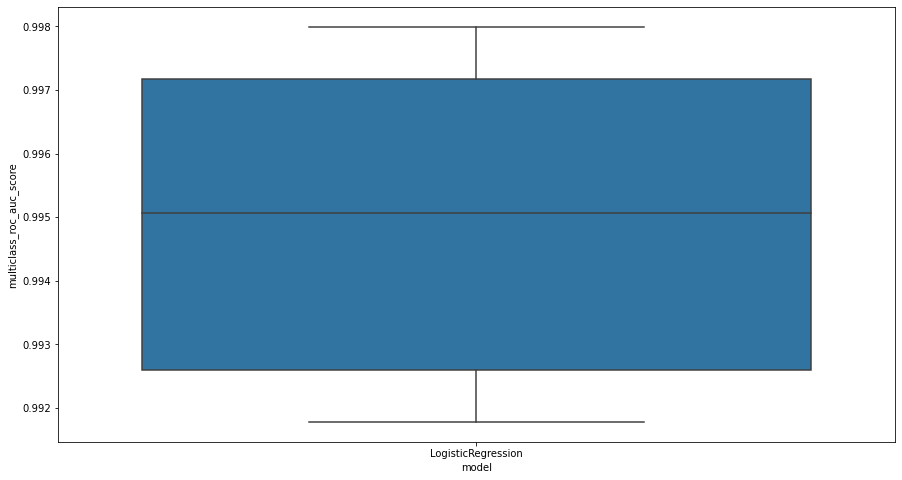

In [64]:
def summarize_metrics(model_dict: Dict, metric_name:str="roc", pos_label:int=1):
    """
    Summarize metrics of each fold with its standard error.
    We also plot a boxplot to show the results.
    """
    
    
    results = []
    
    
    for model_name, model_results in model_dict.items():
        result_dict = model_results.get_result(result_name=metric_name)
        
        tmp_score = []
        for fold, metric in result_dict.items():
            pos_class_score = metric[pos_label]
            results.append((model_name, fold, pos_class_score))
            tmp_score.append(pos_class_score)
        
        # append the Standard Error of K folds
        results.append((model_name, "SE", np.std(tmp_score, ddof=1) / len(tmp_score) ** 0.5))
    
    
    summary_df = pd.DataFrame(results, columns=["model", "fold", metric_name])
    
    fig, ax = plt.subplots(figsize=(15, 8))
    _ = sns.boxplot(x="model", y=metric_name, data=summary_df[(summary_df['model'] != 'DummyClassifier') & (summary_df['fold'] != 'SE')], ax=ax)
    
   # fig.savefig(config.spot_checking_boxplot, format='png', dpi=300)
    
    return summary_df

summary_df = summarize_metrics(model_dict = model_dict, metric_name="multiclass_roc_auc_score")
display(summary_df.tail(12))

### Out-of-Fold Confusion Matrix

We do have information on the performance of each folds, we now look at the performance of all 5 folds together. Typicall there are two ways to do it, one is to simply take the average of the score of five folds, the other is to take a look at out of folds predictions.

---

From the confusion matrix of the out of fold performance, Logistic Regression does seem to be a model we can explore on, although slightly lower in terms of overall AUROC score than SVC, it seems to have the quite low False Negatives amongst all. With further hyperparameter tuning and threshold optimization, we can make it better.

In [65]:
model_names = [model for model in model_dict.keys()]

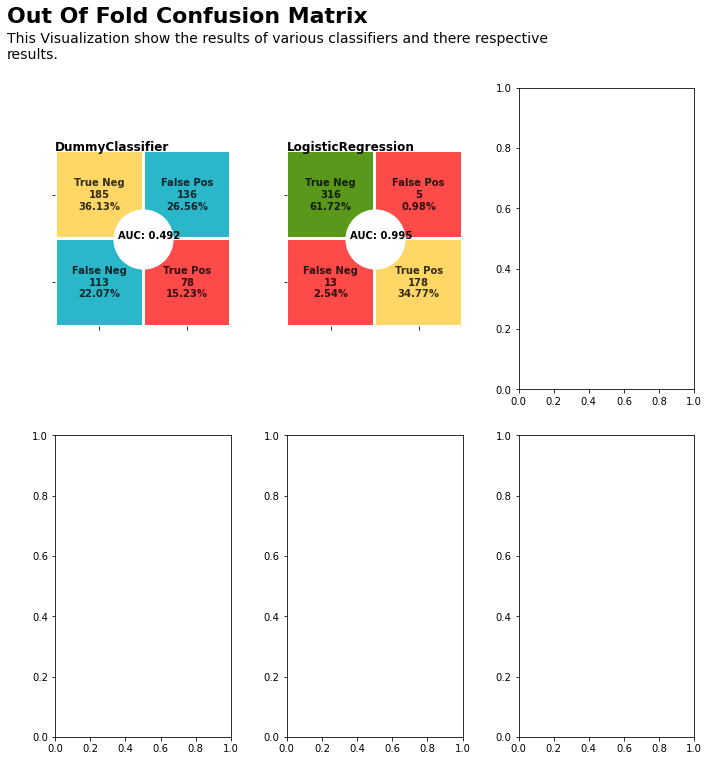

In [70]:
fig, ax = plt.subplots(2, 3, figsize=(10, 10))

for axes, algo in zip(ax.ravel(), model_names):

    cf_mat = results_df.oof_cv[algo].confusion_matrix

    #### scores
    positive_class_auroc = results_df.oof_cv[algo].multiclass_roc_auc_score[1]

    #### annotations
    labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
    counts = ["{0:0.0f}".format(value) for value in cf_mat.flatten()]
    percentages = ["{0:.2%}".format(value) for value in cf_mat.flatten() / np.sum(cf_mat)]

    #### final annotations
    label = (
        np.array([f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, counts, percentages)])
    ).reshape(2, 2)

    # heatmap
    sns.heatmap(
        data=cf_mat,
        vmin=0,
        vmax=330,
        cmap=["#fe4a49", "#2ab7ca", "#fed766", "#59981A"],
        linewidth=2,
        linecolor="white",
        square=True,
        ax=axes,
        annot=label,
        fmt="",
        cbar=False,
        annot_kws={"size": 10, "color": "black", "weight": "bold", "alpha": 0.8},
        alpha=1,
    )

    axes.text(0, -0, "{}".format(algo), {"size": 12, "color": "black", "weight": "bold"})

    axes.scatter(1, 1, s=3500, c="white")
    axes.text(
        0.72,
        1.0,
        "AUC: {}".format(np.round(positive_class_auroc, 3)), 
        {"size": 10, "color": "black", "weight": "bold"},
    )

    ## ticks and labels
    axes.set_xticklabels("")
    axes.set_yticklabels("")


## titles and text
fig.text(0, 1.05, "Out Of Fold Confusion Matrix", {"size": 22, "weight": "bold"}, alpha=1)
fig.text(
    0,
    1,
    """This Visualization show the results of various classifiers and there respective
results.""",
    {"size": 14, "weight": "normal"},
    alpha=0.98,
)


fig.tight_layout(pad=2.5, w_pad=2.5, h_pad=2.5)
# fig.savefig(config.oof_confusion_matrix, format='png', dpi=300)

### Hypothesis Testing Across Models

I am slightly shocked at the performance of plain LogisticRegression, I decide to use an idea from [Hypothesis Testing Across Models](http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_kfold_cv/) to check if the difference is really by chance or not. Note that I will be modifying his code as his code does not split using StratifiedKFold.

---

The basic idea is to test if two model's difference in scores (in this case roc), is statistically significant or not. However, we note that this method may violate an assumption of Student's t test.

---

- Null Hypothesis $H_0$: The difference in the performance score of two classifiers is Statistically Significant.
- Alternate Hypothesis $H_1$: The difference in the performance score of two classifiers is **not** Statistically Significant.

In [ ]:
def paired_ttest_skfold_cv(
    estimator1, estimator2, X, y, cv=10, scoring=None, shuffle=False, random_seed=None
):
    """Modified from https://github.com/rasbt/mlxtend/blob/master/mlxtend/evaluate/ttest.py to accomodate StratifiedKFold"""

    if not shuffle:
        skf = model_selection.StratifiedKFold(n_splits=cv, shuffle=shuffle)
    else:
        skf = model_selection.StratifiedKFold(
            n_splits=cv, random_state=random_seed, shuffle=shuffle
        )

    if scoring is None:
        if estimator1._estimator_type == "classifier":
            scoring = "accuracy"
        elif estimator1._estimator_type == "regressor":
            scoring = "r2"
        else:
            raise AttributeError("Estimator must " "be a Classifier or Regressor.")
    if isinstance(scoring, str):
        scorer = metrics.get_scorer(scoring)
    else:
        scorer = scoring

    score_diff = []

    for train_index, test_index in skf.split(X=X, y=y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        estimator1.fit(X_train, y_train)
        estimator2.fit(X_train, y_train)

        est1_score = scorer(estimator1, X_test, y_test)
        est2_score = scorer(estimator2, X_test, y_test)
        score_diff.append(est1_score - est2_score)

    avg_diff = np.mean(score_diff)

    numerator = avg_diff * np.sqrt(cv)
    denominator = np.sqrt(sum([(diff - avg_diff) ** 2 for diff in score_diff]) / (cv - 1))
    t_stat = numerator / denominator

    pvalue = stats.t.sf(np.abs(t_stat), cv - 1) * 2.0
    return float(t_stat), float(pvalue)


In [ ]:
# check if difference between algorithms is real
X_tmp = X_y_train[predictor_cols].values
y_tmp = X_y_train['diagnosis'].values

t, p = paired_ttest_skfold_cv(estimator1=classifiers[1], estimator2=classifiers[-1],shuffle=True,cv=5, X=X_tmp, y=y_tmp, scoring='roc_auc', random_seed=config.seed)

In [ ]:
print('P-value: %.3f, t-Statistic: %.3f' % (p, t))

Since P value is quite high, and more the basic threshold of 0.05 or 0.1, we fail to reject the null hypothesis, and say that there is no significant difference between these two models.

## Model Selection: Hyperparameter Tuning with GridSearchCV

<div class="alert alert-success" role="alert">
    <b>Hyperparameter Tuning:</b>
    <li> We have done a quick spot checking on algorithms and realized that <code>LogisticRegression</code> is doing well for this task. For this purpose, I will just perform hyperparameter tuning on this single algorithm. However, in practice and if resources are allowed, I will also tune other models such as <code>RandomForest()</code>, or gradient boosting algorithms such as <code>XGBoost</code>, as I believe they will perform no worse than our Logistic Regression model given the right hyperparameters.
</div>

---

<div class="alert alert-info" role="alert">
    <b>Grid Search:</b>
    <li> We will use an old-fashioned way to search for hyperparameters, which is brute force method. The time complexity of Grid Search is high and if you have many hyperparameters to tune, I recommend trying out <b>Random Grid Search</b> or libraries like <b>Optuna</b> that uses Bayesian Optimization.
</div>

In [ ]:
def make_finetuning_pipeline(model):
    """Make a Pipeline for Training.

    Args:
        model ([type]): [description]

    Returns:
        [type]: [description]
    """
    
    steps = list()
    # standardization
    steps.append(('standardize', preprocessing.StandardScaler()))
    # reduce VIF
    steps.append(('remove_multicollinearity', ReduceVIF(thresh=10)))
    # the model
    steps.append(('model', model))
    # create pipeline
    _pipeline = pipeline.Pipeline(steps=steps)
    return _pipeline

Reconstruct our pipeline but now only taking in `LogisticRegression`.

In [ ]:
pipeline_logistic = make_finetuning_pipeline(
    linear_model.LogisticRegression(
        solver="saga", random_state=config.seed, max_iter=10000, n_jobs=None, fit_intercept=True
    )
)

Define our search space for the hyperparameters:

```python
param_grid = {model__penalty=["l1", "l2"],
              model__C=np.logspace(-4, 4, 10)}
```

In [ ]:
param_grid = dict(
    model__penalty=["l1", "l2"],
    model__C=np.logspace(-4, 4, 10),
)

Run our hyperparameter search with cross-validation. For example, our `param_grid` has $2 \times 10 = 20$ combinations, and our cross validation has 5 folds, then there will be a total of 100 fits.

---

Below details the pseudo code of what happens under the hood:

- Define $G$ as the set of combination of hyperparamters. Define number of splits to be $K$.
- For each set of hyperparameter $z \in Z$:
    - for fold $j$ in K:
        - Set $F_{\text{train}}=\bigcup\limits_{i\neq k}^{K} F_{i}$
        - Set $F_{\text{val}} = F_{j}$ as the validation set
        - Perform Standard Scaling on $F_{\text{train}}$ and find the mean and std
        - Perform VIF recursively on $F_{\text{train}}$ and find the selected features
        - Transform $F_{\text{val}}$ using the mean and std found using $F_{\text{train}}$
        - Transform $F_{\text{val}}$ to have only the selected features from $F_{\text{train}}$
        - Train and fit on $F_{\text{train}}$ 
    - Evaluate the fitted parameters on $F_{\text{val}}$ to obtain $\mathcal{M}$


In [ ]:
grid = model_selection.GridSearchCV(pipeline_logistic, param_grid=param_grid, cv=5, refit=True, verbose=3, scoring = "roc_auc")
_ = grid.fit(X_train, y_train)

We can save our results in a dataframe, we will also look at the top performing hyperparameter by querying the below:

```python
grid_cv_df = pd.DataFrame(grid.cv_results_)
grid_cv_df.loc[grid_cv_df['rank_test_score']==1]
```

In [ ]:
grid_cv_df = pd.DataFrame(grid.cv_results_)
best_cv = grid_cv_df.loc[grid_cv_df['rank_test_score']==1]
display(best_cv)

best_hyperparams = grid.best_params_
print(f"Best Hyperparameters found is {best_hyperparams}")

Our best performing set of hyperparameters `{'model__C': 0.3593813663804626, 'model__penalty': 'l2'}` gives rise to a mean cross validation score of $0.988739$, which is higher than the model with default hyperparameter scoring, $0.987136$.

<div class="alert alert-success" role="warning">
    <b>Room for Improvement:</b> Apart from the other methods to search for the optimal hyperparameters, we can also include preprocessing step as a tunable hyperparameter. More specifically, in our <code>ReduceVIF()</code> step, we hard coded two manual criterion in which the algorithm will stop; if the threshold reaches 10, or if the number of features removed hit 20; we can include them in the search space.
</div>

## Retrain on the whole training set

A common practice after the hyperparameter tuning phase is to retrain the model on the whole dataset $X_{\text{train}}$ where we will get the estimator's coefficients obtained from the retraining. This is actually already done as the scikit-learn's `GridSearchCV` has a parameter `refit`; if we select it to be true, then after the model selection process is done (i.e. getting the best hyperparameters after cross validation with grid search), the grid search object will retrain on the whole $X_{\text{train}}$ with the best hyperparameters internally, and return us back an object in which we can call `predict` etc.

### Retrain using optimal hyperparameters

However, to be extra careful, we can retrain manually using the best hyperparameters and check if scikit-learn is true to its documentation. We will just reconstruct the pipeline using the grid's best hyper parameters. We will then test if the retrained model's coefficients coincide with the grid's best estimator's coefficients. If there difference is 0, this means they are trained under the same circumstances and we can be sure that the refit parameter is behaving true to its words.

---

```python
grid_best_hyperparams = grid.best_params_
print(grid_best_hyperparams) ->
{'model__C': 0.3593813663804626,
 'model__penalty': 'l2'}
```

In [ ]:
retrain_pipeline = pipeline.Pipeline(
    [
        ("standardize", preprocessing.StandardScaler()),
        ('remove_multicollinearity', ReduceVIF(thresh=10)),

        (
            "model",
            linear_model.LogisticRegression(
                C=0.3593813663804626, max_iter=10000, random_state=1992, solver="saga", penalty="l1"
            ),
        ),
    ]
)

_ = retrain_pipeline.fit(X_train, y_train)
coef_diff = retrain_pipeline['model'].coef_ - grid.best_estimator_['model'].coef_

print("...")
assert np.all(coef_diff == 0) == True
print("Retraining Assertion Passed!")

## Interpretation of Results

### Interpretation of Coefficients

As shown in the figure below, all else being equal, for every square unit increase in mean cell area, the odds of the tumor being malignant increases by a factor of $e^{1.43} = 4.19$. The variation (standard error) of the characteristics of cells also are deemed important by the model, for example, area se played an important role in determining whether a cell is malignant; intuitively, if some cells are noticably larger than the rest, then it is also a good indicator of malignancy.

In [ ]:
selected_features_by_vif_index = grid.best_estimator_['remove_multicollinearity'].column_indices_kept_ 
selected_feature_names = np.asarray(predictor_cols)[selected_features_by_vif_index]

selected_features_coefficients = grid.best_estimator_['model'].coef_.flatten()

# assertion
#assert grid.best_estimator_['remove_multicollinearity'].feature_names_ == retrain_pipeline['remove_multicollinearity'].feature_names_

fig, ax = plt.subplots(figsize=(15, 15))
# .abs()
_ = pd.Series(selected_features_coefficients, index=selected_feature_names).sort_values().plot(ax=ax, kind='barh')
fig.savefig(config.feature_importance, format="png", dpi=300)

### Interpretation of Metric Scores on Train Set

We are also interested in choosing an optimal threshold for the model such that it gives the lowest recall, or False Negatives. We note that the default threshold when calling `predict()` from a model is $0.5$. In this section, we will explore one way to get the best tradeoff we can when choosing a high recall, while maintaining a reasonable score for precision.

In [ ]:
def evaluate_train_test_set(
    estimator: Callable, X: Union[pd.DataFrame, np.ndarray], y: Union[pd.DataFrame, np.ndarray]
) -> Dict[str, Union[float, np.ndarray]]:
    """This function takes in X and y and returns a dictionary of scores.

    Args:
        estimator (Callable): [description]
        X (Union[pd.DataFrame, np.ndarray]): [description]
        y (Union[pd.DataFrame, np.ndarray]): [description]

    Returns:
        Dict[str, Union[float, np.ndarray]]: [description]
    """

    test_results = {}

    y_pred = estimator.predict(X)
    # This is the probability array of class 1 (malignant)
    y_prob = estimator.predict_proba(X)[:, 1]

    test_brier = metrics.brier_score_loss(y, y_prob)
    test_roc = metrics.roc_auc_score(y, y_prob)

    test_results["brier"] = test_brier
    test_results["roc"] = test_roc
    test_results["y"] = np.asarray(y).flatten()
    test_results["y_pred"] = y_pred.flatten()
    test_results["y_prob"] = y_prob.flatten()

    return test_results


In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.89 
    and courtesy of https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.savefig(config.precision_recall_threshold_plot, format="png", dpi=300)
    
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    and courtesy of https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
    plt.savefig(config.roc_plot, format="png", dpi=300)
    
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    and courtesy of https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
    """
    return [1 if y >= t else 0 for y in y_scores]

The plots below show the tradeoffs between precision and recall, recall and false positive rate. The confusion matrix on the train set tells us that there is still more false negatives than false positives. We can choose a particular threshold in order to minimize false negatives, at some expense of false positive.

In [ ]:
train_results = evaluate_train_test_set(grid, X_train, y_train)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# CM
cm_train = metrics.confusion_matrix(train_results['y'], train_results['y_pred'])

#### scores
auc = metrics.roc_auc_score(train_results['y'], train_results['y_prob'])

#### annotations
labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
counts = ["{0:0.0f}".format(value) for value in cm_train.flatten()]
percentages = ["{0:.2%}".format(value) for value in cm_train.flatten() / np.sum(cm_train)]

#### final annotations
label = (
    np.array([f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, counts, percentages)])
).reshape(2, 2)

# heatmap
sns.heatmap(
    data=cm_train,
    vmin=0,
    vmax=330,
    cmap=["#fe4a49", "#2ab7ca", "#fed766", "#59981A"],
    linewidth=2,
    linecolor="white",
    square=True,
    ax=ax,
    annot=label,
    fmt="",
    cbar=False,
    annot_kws={"size": 10, "color": "black", "weight": "bold", "alpha": 0.8},
    alpha=1,
)



ax.scatter(1, 1, s=3500, c="white")
ax.text(
    0.72,
    1.0,
    "AUC: {}".format(round(auc, 3)),
    {"size": 10, "color": "black", "weight": "bold"},
)

## ticks and labels
ax.set_xticklabels("")
ax.set_yticklabels("")


## titles and text
fig.text(0, 1.05, "Train Set Confusion Matrix", {"size": 22, "weight": "bold"}, alpha=1)
fig.text(
    0,
    1,
    """Training Set Confusion Matrix.""",
    {"size": 12, "weight": "normal"},
    alpha=0.98,
)


fig.tight_layout(pad=2.5, w_pad=2.5, h_pad=2.5)
fig.savefig(config.final_train_confusion_matrix, format='png', dpi=300)

In [ ]:
# generate the precision recall curve
precision, recall, pr_thresholds = metrics.precision_recall_curve(train_results['y'], train_results['y_prob'])
fpr, tpr, roc_thresholds = metrics.roc_curve(train_results['y'], train_results['y_prob'], pos_label=1)

In [ ]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(precision, recall, pr_thresholds)

Based on the tradeoff plot above, a good threshold can be set at $t = 0.35$, let us see how it performs with this threshold.

In [ ]:
y_pred_adj = adjusted_classes(train_results["y_prob"], t=0.35)

print(
    pd.DataFrame(
        metrics.confusion_matrix(train_results["y"], y_pred_adj),
        columns=["pred_neg", "pred_pos"],
        index=["neg", "pos"],
    )
)

In [ ]:
print(metrics.classification_report(y_true=train_results["y"], y_pred=y_pred_adj))
train_brier = train_results['brier']
print(f"train brier: {train_brier}")

The False Negatives reduced from 15 to 9, at the expense of increase False Positives from 6 to 14. We should take comfort that less patients are falsely classified as benign when in fact they need treatment. This is a tradeoff that we have to choose. The ROC curve below also paints a similar story, in order for you to have high recall, one must accept that there will more False Positives.

In [ ]:
plot_roc_curve(fpr, tpr, 'recall_optimized')

# Evaluation on Test Set

Ultimately, we are interested in finding the estimate of the generalization error of the model, and thus it is time for us to evaluate our model's performance on the "unseen" test set $X_{\text{test}}$ to get a good gauge on how well the model generalizes to unseen data. Take note that now everything has settled, we will use the exact hyperparameters to predict on test set, with the pre-defined threshold of 0.35.

In [ ]:
test_results = evaluate_train_test_set(grid, X_test, y_test)
y_test_pred_adj = adjusted_classes(test_results['y_prob'], t=0.35)

print(pd.DataFrame(metrics.confusion_matrix(test_results['y'], y_test_pred_adj),
                   columns=['pred_neg', 'pred_pos'], 
                   index=['neg', 'pos']))

In [ ]:
test_roc = test_results['roc']
test_brier = test_results['brier']
print(test_roc)
print(test_brier)
print(metrics.classification_report(y_true=test_results["y"], y_pred=y_test_pred_adj))

Using the same threshold we used on training set, we see that the False Negative is quite low. The overall ROC score is 0.9828, and the corresponding Brier Score is 0.04136, both seem reasonably well performing.

# Benefit Structure

Refer to health insurance project!

# Bias-Variance Tradeoff

In [ ]:
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        grid.best_estimator_['model'], X_train.values, y_train.values, X_test.values, y_test.values, 
        loss='0-1_loss',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

We use the `mlxtend` library to estimate the Bias-Variance Tradeoff in our Logistic Regression model. The core idea behind this function is to use bagging and repeatedly sample from our training set so as to simulate that we are actually drawing samples from the "true" population over a distribution $\mathcal{P}$. 

---

As expected, Logistic Regression being a linear model, its simplicity contributes to its high bias and low variance. 